# Perform one sample test in control cells

Both HBECs and PBMCs

In [4]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [5]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [226]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [247]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [248]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [249]:
adata.shape

(69958, 36588)

### Setup memento

In [250]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [251]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [252]:
memento.setup_memento(adata, q_column='q')

In [253]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


In [254]:
adata.uns['memento'].keys()

dict_keys(['q_column', 'all_q', 'estimator_type', 'filter_mean_thresh', 'num_bins', 'least_variable_genes', 'all_1d_moments'])

### Perform one sample test on ciliated, control cells

In [255]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [256]:
memento.create_groups(adata_ctrl, label_columns=['donor'])

In [257]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [329]:
adata_ctrl.uns['memento']['1d_ht']

{'design_df':    donor
 0  d2513
 1  d2614,
 'design_matrix': array([[1.],
        [1.]]),
 'design_matrix_cols': ['Intercept'],
 'cov_column': 'Inter',
 'mean_coef': array([-2.07332764, -2.19453786, -1.17751624, ..., -2.63663767,
        -1.42957246, -2.11682703]),
 'mean_se': array([0.10364238, 0.10485163, 0.06857478, ..., 0.14239694, 0.07245671,
        0.1254814 ]),
 'mean_asl': array([4.46071249e-06, 1.93071496e-07, 1.09850786e-04, ...,
        2.24264878e-07, 6.70285722e-05, 1.12787150e-08]),
 'var_coef': array([-0.3979442 , -0.37373431, -0.11849583, ..., -0.22189127,
        -0.4416437 ,  1.31222832]),
 'var_se': array([0.58590023, 0.70671308, 0.48796259, ..., 0.39265129, 0.54542086,
        0.48553311]),
 'var_asl': array([0.4019598 , 0.50524948, 0.78512149, ..., 0.56094391, 0.44065593,
        0.01429857])}

In [267]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    7.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   16.3s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   27.6s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   41.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   58.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.1min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.6min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed:  3.2min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed:  3.8min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed:  4.5min
[Parallel(n_jobs=13)]: Done 9774 tasks      | elapsed:  5.2min
[Parallel(n_jobs=13)]: Done 10150 out of 1015

In [268]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [269]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [318]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.01 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.01 & dv_coef < 0').gene.tolist()

In [319]:
len(hv_genes)

439

In [320]:
# for gene in hv_genes:
#     print(gene)

In [321]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
5204,IFIT2,-0.469849,0.126099,3.953537e-04,2.978472,0.264624,1.078504e-07,0.000056
5205,IFIT3,-0.020981,0.074136,7.819218e-01,2.309936,0.225708,1.026336e-07,0.000056
5206,IFIT1,0.274242,0.062177,2.325850e-04,1.955586,0.147678,1.021278e-07,0.000056
5207,IFIT5,-1.348701,0.077320,1.052077e-04,0.078432,0.435527,8.380162e-01,0.933787
5386,IFITM2,-0.005149,0.062959,9.374063e-01,1.715650,0.194331,1.031083e-05,0.000497
5387,IFITM1,-0.627829,0.082304,6.146045e-06,2.059088,0.223067,7.942949e-06,0.000409
5388,IFITM3,1.395832,0.039112,9.015190e-07,1.245325,0.167175,9.742354e-06,0.000482
5419,IFITM10,-0.080528,0.050650,1.113889e-01,0.986147,0.133651,5.576556e-05,0.001572


In [322]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head(20)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
9347,BPIFA1,1.711823,0.237689,5.680082e-06,4.772759,0.180577,9.999000e-05,0.002441
5086,MSMB,2.002644,0.234068,2.744511e-06,4.753874,0.318063,7.979067e-09,0.000040
1640,CCL20,-0.122780,0.208679,5.513449e-01,4.453336,0.177138,7.499908e-07,0.000099
5618,SCGB1A1,1.821146,0.175603,2.689204e-06,4.449934,0.141542,3.148436e-08,0.000048
9591,TFF3,1.162709,0.201850,2.002919e-05,4.414665,0.411461,3.775934e-07,0.000081
9348,BPIFB1,2.132191,0.159921,2.821398e-07,4.029002,0.151121,1.170333e-06,0.000121
2800,CDC20B,-0.837752,0.207628,1.199880e-03,3.995393,0.101076,2.083444e-08,0.000048
5416,MUC5B,-0.609397,0.172134,1.151569e-03,3.798337,0.186431,5.039371e-07,0.000082
6281,TSPAN8,-1.275266,0.222928,1.344198e-04,3.763758,0.450819,3.045219e-07,0.000076
2802,CCNO,0.747182,0.125574,5.436508e-05,3.682878,0.098407,2.822953e-09,0.000029


In [323]:
hbec_1d = onesamp_ht_df[['gene', 'dv_coef']].copy()

In [324]:
with open('hv_genes.pkl', 'wb') as f:
    pkl.dump(hv_genes, f)

### Enrichment for HBECs

In [325]:
import gseapy as gp

In [326]:
# enr = gp.enrichr(
#     gene_list=hv_genes,
#     gene_sets=['KEGG_2016'],
#     organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
#     description='test_name',
#     outdir='./gsea/',
#     # no_plot=True,
#     cutoff=0.5 # test dataset, use lower value from range(0,1)
#     )

enr2 = gp.enrichr(
    gene_list=hv_genes,
    gene_sets=['Reactome_2016'],
    organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
    description='test_name',
    outdir='./gsea/',
    # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
    )

In [327]:
df = enr2.results.sort_values('Adjusted P-value').head(50)
df['log_p'] = -np.log10(df['P-value'])
df['term'] = df['Term'].apply(lambda x : ' '.join(x.split(' ')[:-3]))
df['term'] = df['term'].apply(lambda x: x if len(x.split(' ')) < 4 else ' '.join(x.split(' ')[:2]) + '\n'+ ' '.join(x.split(' ')[2:]))

In [328]:
df.head(30)[['term', 'Adjusted P-value']]

,term,Adjusted P-value
0,Interferon alpha/beta signaling,3.354135e-12
1,Interferon Signaling,7.418080e-11
2,Cellular Senescence,2.419183e-05
3,TP53 Regulates\nTranscription of Cell Cycle Genes,1.260792e-04
4,Senescence-Associated Secretory\nPhenotype (SASP),1.260792e-04
5,Cytokine Signaling\nin Immune system,1.260792e-04
6,RHO GTPases\nactivate PKNs,4.957592e-03
7,Cellular responses\nto stress,6.139133e-03
8,Translocation of\nZAP-70 to Immunological synapse,6.139133e-03
9,Phosphorylation of\nCD3 and TCR zeta chains,1.093102e-02


In [307]:
# plt.figure(figsize=(2, 3))
# sns.barplot(x='log_p', y='term', data=df.head(15), palette='Set2')
# plt.ylabel(None); plt.xlabel('-log P')

# plt.savefig(fig_path + 'enrichment.pdf', bbox_inches='tight')


In [308]:
gene_set_hits = df.head(10)['Genes']
gene_set_hits = [x.split(';') for x in gene_set_hits]

### Mean vs variability plots for ctrl cells

In [309]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

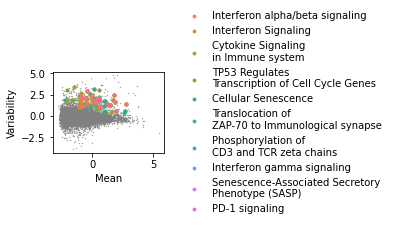

In [310]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
# plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=0.2,color='k')


for gene_set, label, color in zip(gene_set_hits, df.head(10)['term'].tolist(), sns.color_palette('husl', 10)):
    plt.scatter(
        m_df.query('gene in @gene_set')['ALL_sg'], 
        v_df.query('gene in @gene_set')['ALL_sg'], 
        s=8,color=color, label=label)
    
for gene_set, label, color in zip(gene_set_hits[::-1], df.head(10)['term'].tolist()[::-1], sns.color_palette('husl', 10)[::-1]):
    plt.scatter(
        m_df.query('gene in @gene_set')['ALL_sg'], 
        v_df.query('gene in @gene_set')['ALL_sg'], 
        s=8,color=color)

plt.xlabel('Mean'); plt.ylabel('Variability');
plt.legend(loc='center left', frameon=False, bbox_to_anchor=(1.1,0.5))
plt.savefig(fig_path + 'm_vs_v_onesamp_enrich.png', bbox_inches='tight', dpi=300)


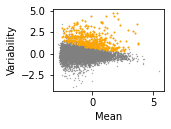

In [146]:
plt.figure(figsize=(2, 1.5))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp.png', bbox_inches='tight', dpi=300)


### Compare to naive estimators


In [61]:
adata_ctrl = adata.copy()[
    adata.obs.cell_type.isin(['ciliated']) & \
    adata.obs.stim.isin(['control']), :].copy()
adata_ctrl.obs['group'] = 'A'

In [62]:
memento.create_groups(adata_ctrl, label_columns=['group'])

In [63]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.9)

In [64]:
sf = adata_ctrl.obs['memento_size_factor'].values

In [65]:
naive_m = (adata_ctrl.X/sf.reshape(-1, 1)).mean(axis=0).A1
naive_v = (adata_ctrl.X/sf.reshape(-1, 1)).var(axis=0).A1

In [67]:
memento_m, memento_v, _ = adata_ctrl.uns['memento']['1d_moments']['sg^A']

In [70]:
memento_cv = memento_v/memento_m**2
naive_cv = naive_v/naive_m**2

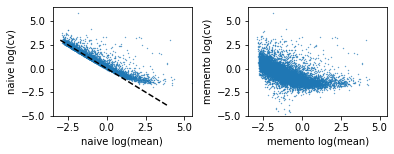

In [92]:
plt.figure(figsize=(6, 2));
plt.subplots_adjust(wspace=0.4)
plt.subplot(1, 2, 1);
plt.scatter(np.log(naive_m), np.log(naive_cv), s=0.1)
plt.plot([-3, 4], [3, -4], '--',color='k')
plt.xlabel('naive log(mean)'); plt.ylabel('naive log(cv)')
plt.xlim(-3.5, 5.5); plt.ylim(-5, 6.5)
plt.subplot(1, 2, 2);
plt.scatter(np.log(memento_m), np.log(memento_cv), s=0.1)
plt.xlim(-3.5, 5.5); plt.ylim(-5, 6.5)
plt.xlabel('memento log(mean)'); plt.ylabel('memento log(cv)')

fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'
plt.savefig(fig_path + 'm_vs_cv.png', bbox_inches='tight', dpi=300)


In [54]:
naive_m

array([0.12720141, 0.111439  , 0.31076068, ..., 0.07160998, 0.23941539,
       0.12352613], dtype=float32)

In [39]:
memento_m = memento_m['ALL_sg'].values

,gene,ALL_sg
0,LINC01409,-2.073328
1,FAM41C,-2.194538
2,NOC2L,-1.177516
3,HES4,0.790288
4,ISG15,1.825076
...,...,...
10145,BRCC3,-1.815602
10146,VBP1,-1.051313
10147,TMLHE,-2.636638
10148,VAMP7,-1.429572


### Check the result in PBMCs

In [191]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/supp/'
data_path = '/data_volume/parameter_estimation/'

#### Read PBMC dataset and setup memento

In [192]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [193]:
def simplify_name(name):
    return name.split('.')[0]

In [194]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')

In [195]:
adata.obs['q'] = 0.07

In [196]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

#### Isolate the control cells and perform one sample test

In [197]:
adata_ctrl = adata.copy()[(adata.obs['cell']=='CD14+ Monocytes') & (adata.obs['stim']=='stim')].copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [198]:
adata_ctrl.obs.head(2)

,tsne1,tsne2,ind,stim,cluster,cell,multiplets,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,cell_type,q,memento_size_factor
index,,,,,,,,,,,,,,,,,,,,
AAACATACGCGAAG-1,3.550854,35.214427,101,stim,8,CD14+ Monocytes,singlet,1319,7.185387,5312.0,8.577912,0.0,0.0,0.0,0.0,0.0,0.0,CD14+ Monocytes - stim,0.07,1.528051
AAACATACTCAGGT-1,6.290151,26.974231,1016,stim,8,CD14+ Monocytes,singlet,563,6.335054,2152.0,7.674617,0.0,0.0,0.0,0.0,0.0,0.0,CD14+ Monocytes - stim,0.07,0.912694


In [199]:
memento.create_groups(adata_ctrl, label_columns=['ind'])

In [200]:
memento.compute_1d_moments(adata_ctrl, min_perc_group=.7)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log


In [201]:
memento.ht_1d_moments(
    adata_ctrl,
    formula_like='1',
    cov_column='Inter',
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    4.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   13.1s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   27.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   49.2s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 1938 out of 1938 | elapsed:  2.0min finished


In [202]:
onesamp_ht_df = memento.get_1d_ht_result(adata_ctrl)

In [203]:
onesamp_ht_df['dv_fdr'] = memento.util._fdrcorrect(onesamp_ht_df['dv_pval'])

In [204]:
hv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef > 0').gene.tolist()
lv_genes = onesamp_ht_df.query('dv_fdr < 0.001 & dv_coef < 0').gene.tolist()

In [205]:
# for gene in hv_genes:
#     print(gene)

In [206]:
m_df, v_df = memento.get_1d_moments(adata_ctrl, groupby='ALL')

In [207]:
onesamp_ht_df.query('dv_coef > 0 & dv_fdr < 0.001')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
0,HES4,0.080432,0.029661,7.399260e-03,0.992417,0.076755,7.553380e-06,0.000136
27,FUCA1,-1.501005,0.068328,1.001264e-06,1.608537,0.146463,1.015720e-06,0.000039
49,MARCKSL1,-0.036962,0.030038,2.218778e-01,0.818790,0.093134,5.751629e-06,0.000114
115,C1orf162,-1.658952,0.061394,1.046774e-06,1.158069,0.144292,5.454292e-06,0.000114
142,S100A9,0.838761,0.026230,3.520033e-07,1.238203,0.059355,2.103018e-07,0.000019
...,...,...,...,...,...,...,...,...
1886,HMOX1,-0.156773,0.037087,3.374185e-04,1.463340,0.081956,3.216310e-07,0.000023
1891,LGALS2,-1.435091,0.072567,7.682750e-07,0.828509,0.121365,6.839868e-05,0.000762
1892,LGALS1,1.919101,0.014215,4.742131e-06,0.272317,0.042045,5.974301e-05,0.000681
1896,RPL3,0.812561,0.022084,4.820466e-08,0.765117,0.065565,2.759956e-06,0.000078


In [208]:
pbmc_1d = onesamp_ht_df[['gene', 'dv_coef', 'dv_fdr']].copy()

In [209]:
joined = pbmc_1d.merge(hbec_1d, on='gene', suffixes=('_pbmc', '_hbec'))

In [210]:
stats.pearsonr(joined['dv_coef_pbmc'], joined['dv_coef_hbec'])

(0.3386708837306288, 1.9589171103078664e-43)

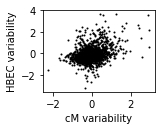

In [227]:
plt.figure(figsize=(2, 1.5))
plt.scatter(joined['dv_coef_pbmc'], joined['dv_coef_hbec'], s=1, color='k')
plt.xlabel('cM variability'); plt.ylabel('HBEC variability')
plt.savefig(fig_path + 'pbmc_vs_hbec_var.png', bbox_inches='tight', dpi=300)


In [218]:
joined['diff'] = (joined['dv_coef_pbmc']-joined['dv_coef_hbec']).abs()

In [223]:
joined.query('dv_coef_hbec > 1.5').sort_values('diff', ascending=True).head(30)

,gene,dv_coef_pbmc,dv_fdr,dv_coef_hbec,diff
1366,SERPINB2,2.419651,0.000032,2.349773,0.069878
751,FABP5,2.387488,0.000114,2.634875,0.247387
562,HLA-DPB1,1.197051,0.000142,1.501768,0.304717
561,HLA-DPA1,1.128060,0.000036,1.582071,0.454011
859,DDIT4,1.552022,0.002928,2.123719,0.571697
406,CXCL3,2.900144,0.000006,3.573302,0.673158
964,CTSC,1.646717,0.000038,2.322350,0.675634
900,HBB,2.978186,0.000002,2.195298,0.782888
908,ADM,0.762776,0.005682,1.562819,0.800042
543,IER3,1.150529,0.003085,2.025402,0.874873


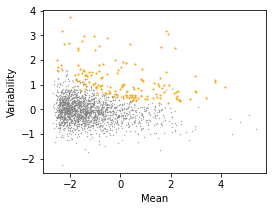

In [38]:
plt.figure(figsize=(4, 3))
plt.scatter(m_df['ALL_sg'], v_df['ALL_sg'], s=0.1,color='gray')
plt.scatter(m_df.query('gene in @hv_genes')['ALL_sg'], v_df.query('gene in @hv_genes')['ALL_sg'], s=1,color='orange')
plt.xlabel('Mean'); plt.ylabel('Variability');
plt.savefig(fig_path + 'm_vs_v_onesamp_pbmc.png', bbox_inches='tight', dpi=300)


In [36]:
onesamp_ht_df.sort_values('dv_coef', ascending=False).head(20)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
295,IL1B,-2.010218,0.200637,1.685939e-05,3.740840,0.342575,9.414523e-10,9.122672e-07
280,GNLY,-2.336887,0.178715,1.062464e-06,3.196390,0.338151,3.151618e-07,2.035945e-05
1599,CCL4,1.829208,0.060254,1.891437e-08,3.194377,0.103889,1.022157e-08,3.170909e-06
1598,CCL3,1.894398,0.051078,8.075448e-10,3.052662,0.159610,2.131682e-07,1.530074e-05
1509,NUPR1,-1.053738,0.088842,1.710292e-04,2.981152,0.126372,1.002254e-07,9.249370e-06
1102,HBB,-1.452393,0.136822,8.506516e-06,2.978186,0.420924,2.290646e-08,3.170909e-06
489,CXCL3,-0.541382,0.079517,4.171528e-04,2.900144,0.106330,6.977687e-07,3.467374e-05
1605,CCR7,-1.555124,0.093630,1.050379e-06,2.783267,0.200630,2.216089e-08,3.170909e-06
1600,CCL3L1,-2.046472,0.123018,1.458550e-06,2.684193,0.262395,6.184054e-07,3.153867e-05
487,IL8,0.399955,0.052920,5.748862e-06,2.666414,0.081006,7.954302e-08,8.113388e-06


In [29]:
onesamp_ht_df.query('gene.str.contains("IFIT")', engine='python')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr
1062,IFIT2,2.123506,0.016047,2.519822e-10,0.664085,0.053250,8.676343e-06,0.000155
1063,IFIT3,2.360893,0.014359,4.376796e-06,0.343397,0.039582,9.831944e-06,0.000171
1064,IFIT1,2.250409,0.014361,1.355806e-10,0.424394,0.039500,1.182113e-05,0.000194
1065,IFIT5,-1.460855,0.051044,1.509962e-07,0.025312,0.247138,9.143086e-01,0.956234
1086,IFITM2,1.065460,0.015153,1.328423e-05,-0.423400,0.076280,8.121454e-05,0.000865
1087,IFITM1,-1.098009,0.036997,1.352632e-08,-0.647516,0.259061,3.449655e-02,0.130320
1088,IFITM3,2.743918,0.007590,1.333677e-06,-1.239418,0.054461,4.073864e-07,0.000025
